In [65]:
%pylab inline
%load_ext autoreload
%autoreload 2

import psycopg2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from antenna_optimization.utils import tools_new_method as tools
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 数据获取

In [66]:
# 连接数据库
conn = psycopg2.connect(database='feeder', user='feeder_dev',
                        password='feeder_dev', host='192.168.101.66',
                        port='5432')

# 读取工参数据
#query = "SELECT * FROM test_mdt WHERE longitude=119.30127 AND latitude = 26.1057"
#mdt = pd.read_sql_query(query, conn)
#mdt = mdt.sort_values(['s_ci'])
query1 = "SELECT ci, longitude, latitude FROM sm_cl_location"
df_cell_info = pd.read_sql_query(query1, conn)

# 读取划定区域数据
# 选取划定区域 region_1 经度最小值 最大值 维度最小值 最大值
region_1 = [119.30127, 119.33075, 26.1057, 26.13431]
#query = "SELECT s_ci, longitude, latitude, s_rsrp FROM test_mdt WHERE\
#        (longitude BETWEEN {} AND {}) AND (latitude BETWEEN {} AND {})\
#            ".format(region_1[0], region_1[1], region_1[2], region_1[3])

#df_selected_area = pd.read_sql_query(query, conn)
#df_selected_area.to_csv(r"E:\01_work_documents\2018-08\df_selected_area.csv")
df_selected_area = pd.read_csv(r"E:\01_work_documents\2018-08\df_selected_area.csv",
                               index_col=0)

# 仅保留用户数大于500的小区
df_selected_area.groupby(['s_ci']).size().sort_values()
a = df_selected_area.groupby(['s_ci']).size()
b = a[a > 500].index
df_selected_area = df_selected_area[df_selected_area['s_ci'].isin(b)]

D:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [67]:
num_liantiao_limit = 5  # 每个问题小区选取的联调小区个数上限
scope_liantiao = 0.5  # 问题小区扩充多少km为联调小区
tv_weak_cell = 0.005  # 确定弱覆盖小区对应的比率
scope_affected = 0.5  # 联调小区扩充多少km为受影响区域
n_neighbors = 10  # knn回归确定的邻居个数

# 确定待调小区

In [68]:
lst_cells_to_tune = []  # 待调小区 mdt格式

# 确定问题小区
df_selected_area['weak_flag'] =  df_selected_area['s_rsrp'].apply(lambda x: 1 if x < -120 else 0)
a1 = df_selected_area.groupby(['s_ci']).weak_flag.mean()
a2 = a1[a1 > tv_weak_cell]
lst_weak_cell_mdt = a2.index.tolist()
lst_weak_cell_sm = [tools.mdt2smcl(i) for i in lst_weak_cell_mdt]
lst_cells_to_tune.extend(lst_weak_cell_mdt)  # 将问题小区添加到待调小区列表中

# 根据问题小区确定联调小区 
lst_liantiao_mdt = []
for i in range(len(lst_weak_cell_mdt)):
    df_weak_cell = df_selected_area[df_selected_area['s_ci'] == lst_weak_cell_mdt[0]]
    lat_db = df_weak_cell['latitude'].min() - tools.km2lat(km=scope_liantiao)
    lat_ub = df_weak_cell['latitude'].max() + tools.km2lat(km=scope_liantiao)
    lon_lb = df_weak_cell['longitude'].min() - tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_liantiao)
    lon_rb = df_weak_cell['longitude'].max() + tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_liantiao)
    cond1 = df_selected_area['longitude'].between(lon_lb, lon_rb)
    cond2 = df_selected_area['latitude'].between(lat_db, lat_ub)
    df_liantiao_area = df_selected_area[cond1 & cond2]
    # 仅选取用户数排名后五的小区
    a1 = df_liantiao_area['s_ci'].value_counts() / len(df_liantiao_area)
    a1 = a1.sort_values(ascending=True)
    a1 = list(set(a1.index.tolist()) - set(lst_weak_cell_mdt))
    if len(a1) > num_liantiao_limit:
        a1 = a1[:num_liantiao_limit]
    lst_liantiao_mdt.extend(a1)

lst_cells_to_tune.extend(lst_liantiao_mdt)  # 将问题小区添加到待调小区列表中
lst_cells_to_tune = list(set(lst_cells_to_tune))

# 根据待调小区确定获取受影响区域
df_cells_to_tune = df_selected_area[df_selected_area['s_ci'].isin(lst_cells_to_tune)]
lat_db = df_cells_to_tune['latitude'].min() - tools.km2lat(km=scope_affected)
lat_ub = df_cells_to_tune['latitude'].max() + tools.km2lat(km=scope_affected)
lon_lb = df_cells_to_tune['longitude'].min() - tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_affected)
lon_rb = df_cells_to_tune['longitude'].max() + tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_affected)
cond1 = df_selected_area['longitude'].between(lon_lb, lon_rb)
cond2 = df_selected_area['latitude'].between(lat_db, lat_ub)
df_affected_area = df_selected_area[cond1 & cond2]

# 调整

In [71]:
lst_degrees = np.random.uniform(np.pi / 18, np.pi / 3, len(lst_cells_to_tune))  # 确定一个待调整度数
lst_degrees

array([0.48733887, 0.72601973, 0.78023667, 0.50770545, 0.5024591 ,
       0.57532192, 0.51862307, 0.71806687, 0.7159561 , 1.00925381,
       0.68268279, 0.97164459])

D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Add

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

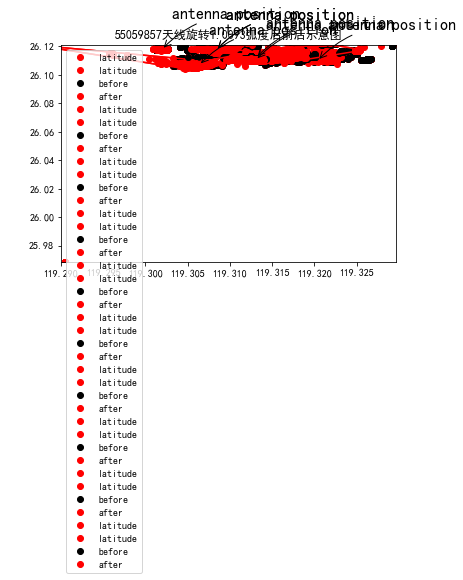

In [77]:
tools.estimate_rsrp_on_given_degrees(df_selected_area, df_selected_area_curr, df_affected_area, df_cell_info, lst_cells_to_tune, lst_degrees)

In [63]:
lst_degree = np.random.uniform(np.pi / 18, np.pi / 3, len(lst_cells_to_tune))  # 确定一个待调整度数
cell_id = 6  # 确定某一个联调小区
some_cell_mdt = lst_liantiao[cell_id]  # 某一个联调小区 
some_cell_sm = tools.mdt2smcl(some_cell_mdt)
degree = lst_degree[cell_id]
data_path = os.path.join(r"E:\data\01_antenna_self_optimize\new_method", some_cell_sm, str(degree)[:5])
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
# copy划定区域数据 在副本上将不断进行删减 删除旋转后丧失的用户点 增加旋转后新增的用户点
df_selected_area_curr = df_selected_area.copy()
del df_selected_area_curr['weak_flag']
df_selected_area_curr['is_est'] = 0

In [ ]:
tools.e

D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


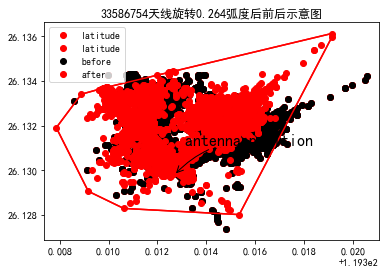

In [64]:
# 旋转与拟合

##  获得以该小区为主区的用户 仅在影响区域中选
df_users = df_affected_area[df_affected_area['s_ci'] == some_cell_mdt]
X = df_users[['longitude', 'latitude']]
sm_cl_curr = df_cell_info[df_cell_info['ci'] == some_cell_sm]
plt.plot(df_users['longitude'], df_users['latitude'], 'ro')
plt.title("{}天线用户原始分布图分布图".format(some_cell_sm))
plt.savefig(os.path.join(data_path, "{}天线用户原始分布图分布图.png".format(some_cell_sm)))

## dbscan 聚类 剔除异常的用户点
X_std = (X - X.mean()) / X.std()
db = DBSCAN(eps=1).fit(X_std)
X_ro = X[db.labels_ != -1]
plt.plot(X_ro['longitude'], X_ro['latitude'], 'ro')
plt.title("{}天线用户去除极端样本后分布图分布图".format(some_cell_sm))
plt.savefig(os.path.join(data_path, "{}天线用户去除极端样本后分布图分布图.png".format(some_cell_sm)))

## 旋转区域
lon_roll, lat_roll = tools.roll_points(X_ro['longitude'], X_ro['latitude'],
                                 sm_cl_curr['longitude'].values[0],
                                 sm_cl_curr['latitude'].values[0],
                                 degree)

## 拟合旋转后的区域
points = np.array([np.array([roll[0], roll[1]]) for roll in zip(lon_roll, lat_roll)])
convex_hull = tools.MinimumBoundingPolygon(points)
bounds = convex_hull.findSmallestPolygon()
convex_hull.plot_scatter_and_bounds(bounds)
plt.title("{}天线旋转{}后覆盖区域拟合图".format(some_cell_sm, round(degree,3)))
plt.savefig(os.path.join(data_path, "{}天线旋转{}弧度后覆盖区域拟合图.png".format(some_cell_sm, round(degree, 3))))

## 绘制旋转前后对比图
fig = plt.figure(num=1, figsize=(15, 15), dpi=80)
ax = fig.add_subplot(1,1,1)
x_min = min(min(lon_roll), X_ro['longitude'].min()) - 0.0005
x_max = max(max(lon_roll), X_ro['longitude'].max()) + 0.0005
y_min = min(min(lat_roll), X_ro['latitude'].min()) - 0.0005
y_max = max(max(lat_roll), X_ro['latitude'].max()) + 0.0005
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
ax.plot(X_ro['longitude'], X_ro['latitude'], 'ko', label="before")
ax.annotate(r'antenna position',
            xy=(sm_cl_curr['longitude'], sm_cl_curr['latitude']),
            xycoords='data',
            xytext=(+10, +30), textcoords='offset points',
            fontsize=16,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2"))
ax.plot(lon_roll, lat_roll, 'ro', label="after")
convex_hull.plot_bounds(bounds)
ax.legend(loc='upper left')
plt.title("{}天线旋转{}弧度后前后示意图".format(some_cell_mdt, round(degree, 4)))
plt.savefig(os.path.join(data_path, "{}天线旋转{}弧度后前后示意图.png".format(some_cell_sm, round(degree, 4))))


# 判断旋转后拟合区域包含的用户点
df_somepoints = df_selected_area.copy()
df_somepoints['is_inside'] = convex_hull.point_in_polygon(df_somepoints[['longitude', 'latitude']], bounds)
df_points_in = df_somepoints[df_somepoints['is_inside'] == True]

# 基于KNN回归估算在新区域用户点的值
"""
#     创建划定区域数据的副本
#     删除无用变量：weak_flag
#     创建指示变量：is_est 表示该用户点的rsrp值是否是估计的 1：估计 0：非估计值
#     对于那些原本在该联调小区覆盖范围，旋转后不在的用户点，在副本中直接将该用户点删除，表示该点已经不再此联调小区的覆盖范围
#     基于当前调整天线所覆盖的用户点建立KNN回归模型
#     将上一步确定在新区域的用点反向旋转相同的度数后，带入KNN回归模型，计算估计的rsrp值
#     构建df_test数据集 包含此联调小区覆盖范围下，各位置估计的rsrp值
#     将df_test追加到副本数据中 表示旋转后新增的用户点
"""

# 在当前联调小区内 不在旋转后该天线覆盖区域的用户点其对应的rsrp值应重置为nan
ix_to_del = df_somepoints[(df_somepoints.is_inside == False) & (df_somepoints.s_ci == some_cell_mdt)].index
df_selected_area_curr = df_selected_area_curr.drop(index=ix_to_del)
X_train = df_users[['longitude', 'latitude']]
y_train = df_users['s_rsrp']
knn = KNeighborsRegressor(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)

lon_roll_back, lat_roll_back = tools.roll_points(df_points_in['longitude'],
                                                 df_points_in['latitude'],
                                                 sm_cl_curr['longitude'].values[0],
                                                 sm_cl_curr['latitude'].values[0],
                                                 -degree)

X_test = pd.DataFrame([lon_roll_back, lat_roll_back]).T
y_test = knn.predict(X_test)

df_test = df_points_in[['longitude', 'latitude', 's_rsrp']].copy()
df_test.index = range(len(df_selected_area_curr), len(df_selected_area_curr) + len(df_test))

df_test['s_rsrp'] = y_test
df_test['s_ci'] = some_cell_sm
df_test['is_est'] = 1
df_selected_area_curr = df_selected_area_curr.append(df_test, sort=True)

# 判断旋转后拟合区域包含的用户点

In [8]:
# 基于KNN回归估算在新区域用户点的值

#     创建划定区域数据的副本
#     删除无用变量：weak_flag
#     创建指示变量：is_est 表示该用户点的rsrp值是否是估计的 1：估计 0：非估计值
#     对于那些原本在该联调小区覆盖范围，旋转后不在的用户点，在副本中直接将该用户点删除，表示该点已经不再此联调小区的覆盖范围
#     基于当前调整天线所覆盖的用户点建立KNN回归模型
#     将上一步确定在新区域的用点反向旋转相同的度数后，带入KNN回归模型，计算估计的rsrp值
#     构建df_test数据集 包含此联调小区覆盖范围下，各位置估计的rsrp值
#     将df_test追加到副本数据中 表示旋转后新增的用户点

# 在当前联调小区内 不在旋转后该天线覆盖区域的用户点其对应的rsrp值应重置为nan
ix_to_del = df_somepoints[(df_somepoints.is_inside == False) & (df_somepoints.s_ci == some_cell_mdt)].index
df_selected_area_curr = df_selected_area_curr.drop(index=ix_to_del)
X_train = df_users[['longitude', 'latitude']]
y_train = df_users['s_rsrp']
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

lon_roll_back, lat_roll_back = tools.roll_points(df_points_in['longitude'],
                                                 df_points_in['latitude'],
                                                 sm_cl_curr['longitude'].values[0],
                                                 sm_cl_curr['latitude'].values[0],
                                                 -degree)

X_test = pd.DataFrame([lon_roll_back, lat_roll_back]).T
y_test = knn.predict(X_test)

df_test = df_points_in[['longitude', 'latitude', 's_rsrp']].copy()
df_test.index = range(len(df_selected_area_curr), len(df_selected_area_curr) + len(df_test))

df_test['s_rsrp'] = y_test
df_test['s_ci'] = some_cell_sm
df_test['is_est'] = 1
df_selected_area_curr = df_selected_area_curr.append(df_test, sort=True)

# 基于KNN回归估算在新区域用户点的值

1. 创建划定区域数据的副本
2. 删除无用变量：weak_flag
3. 创建指示变量：is_est 表示该用户点的rsrp值是否是估计的 1：估计  0：非估计值
4. 对于那些原本在该联调小区覆盖范围，旋转后不在的用户点，在副本中直接将该用户点删除，表示该点已经不再此联调小区的覆盖范围
5. 基于当前调整天线所覆盖的用户点建立KNN回归模型
6. 将上一步确定在新区域的用点反向旋转相同的度数后，带入KNN回归模型，计算估计的rsrp值
7. 构建df_test数据集 包含此联调小区覆盖范围下，各位置估计的rsrp值 
8. 将df_test追加到副本数据中 表示旋转后新增的用户点

In [336]:
# copy划定区域数据 在副本上将不断进行删减 删除旋转后丧失的用户点 增加旋转后新增的用户点
df_selected_area_curr = df_selected_area.copy()
del df_selected_area_curr['weak_flag']
df_selected_area_curr['is_est'] = 0

In [337]:
# 在当前联调小区内 不在旋转后该天线覆盖区域的用户点其对应的rsrp值应重置为nan
ix_to_del = df_somepoints[(df_somepoints.is_inside == False) & (df_somepoints.s_ci == some_cell_mdt)].index
df_selected_area_curr = df_selected_area_curr.drop(index=ix_to_del)

In [338]:
X_train = df_users[['longitude', 'latitude']]
y_train = df_users['s_rsrp']
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

lon_roll_back, lat_roll_back = tools.roll_points(df_points_in['longitude'],
                                                 df_points_in['latitude'],
                                                 sm_cl_curr['longitude'].values[0],
                                                 sm_cl_curr['latitude'].values[0],
                                                 -degree)

X_test = pd.DataFrame([lon_roll_back, lat_roll_back]).T
y_test = knn.predict(X_test)

df_test = df_points_in[['longitude', 'latitude', 's_rsrp']].copy()
df_test.index = range(len(df_selected_area_curr), len(df_selected_area_curr) + len(df_test))

df_test['s_rsrp'] = y_test
df_test['s_ci'] = some_cell_sm
df_test['is_est'] = 1
df_selected_area_curr = df_selected_area_curr.append(df_test, sort=True)